### CSC 5601: Term Project - Isolation Forest (Anomaly Detection) - Sumedha Sanjeev

In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble as skl_e
from isolation_forest import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Loading & Preprocessing

In [2]:
creditcard = pd.read_csv('data/creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
creditcard.isnull().sum().sum()

0

In [4]:
creditcard['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
proportion_outliers = 492 / (492+284315)
proportion_outliers

0.001727485630620034

In [6]:
X = creditcard.drop(columns=['Class','Time']).to_numpy()
y = creditcard['Class']
X.shape

(284807, 29)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Anomaly Detection using implemented `isolation_forest.IsolationForest`

In [8]:
# stratify data based on the labels
stratify_labels = y
num_trees = 100  # number of isolation trees
sub_sampling_size = 512
max_features = 10  # limit number of features for splitting

In [ ]:
isolation_forest = IsolationForest(
    t=num_trees, 
    sub_sampling_size=sub_sampling_size,
    max_features=max_features,
    stratify=y
)

In [31]:
isolation_forest.fit(X_scaled)

In [32]:
# calculating anomaly scores
creditcard['anomaly_score'] = [isolation_forest.anomaly_score(x) for x in X_scaled]

In [33]:
# get the distribution of the anomaly scores
min_score = min(creditcard['anomaly_score'])
max_score = max(creditcard['anomaly_score'])
mean_score = creditcard['anomaly_score'].mean()
median_score = creditcard['anomaly_score'].median()
print("Anomaly score minumum: ", min_score)
print("Anomaly score maximum: ", max_score)
print("Mean Anomaly score minumum: ", mean_score)
print("Median Anomaly score minumum: ", median_score)

Anomaly score minumum:  0.2939257423880048
Anomaly score maximum:  0.8636374178338377
Mean Anomaly score minumum:  0.3059520838335893
Median Anomaly score minumum:  0.2939257423880048


In [ ]:
# threshold for binary labels
threshold = 0.5 * (min_score + mean_score)  # halfway between min and mean
# threshold = creditcard['anomaly_score'].quantile(0.05)  # Bottom 5%
print(threshold)

# map anomaly predictions - 1 for anomaly, 0 for normal
creditcard['anomaly'] = creditcard['anomaly_score'].apply(lambda score: 1 if score < threshold else 0)

result = creditcard.groupby(['Class', 'anomaly']).size()
print(result)

0.299938913110797
Class  anomaly
0      0           67274
       1          217041
1      0             459
       1              33
dtype: int64


#### Anomaly Detection using `sklearn.ensemble.IsolationForest`

TODO: descriptions on sklearn implementation

In [13]:
iso_forest = skl_e.IsolationForest(contamination='auto', random_state=42)
creditcard['skl_anomaly_score'] = iso_forest.fit_predict(X_scaled)

# map anomaly predictions - 1 for anomaly, 0 for normal
creditcard['skl_anomaly'] = creditcard['skl_anomaly_score'].map({1: 0, -1: 1})  

# eval anomalies
print(creditcard[['Class', 'skl_anomaly']].value_counts())

Class  skl_anomaly
0      0              274629
       1                9686
1      1                 402
       0                  90
Name: count, dtype: int64


Class:
- 0: Represents normal transactions.
- 1: Represents fraudulent/anomalous transactions (ground truth)


anomaly:
- 0: Predicted as normal by the Isolation Forest
- 1: Predicted as anomalous by the Isolation Forest

| Class	| Anomaly | Count | Meaning |
| -- | -- | -- | -- |
| 0 | 0 | 274629 | True normal transactions, predicted as normal (True Negatives). |
| 0 | 1 | 9686 | True normal transactions, predicted as anomalies (False Positives). |
| 1 | 0 | 402 | True anomalies (fraud), predicted as normal (False Negatives). |
| 1 | 1 | 90 | True anomalies (fraud), predicted as anomalies (True Positives) |


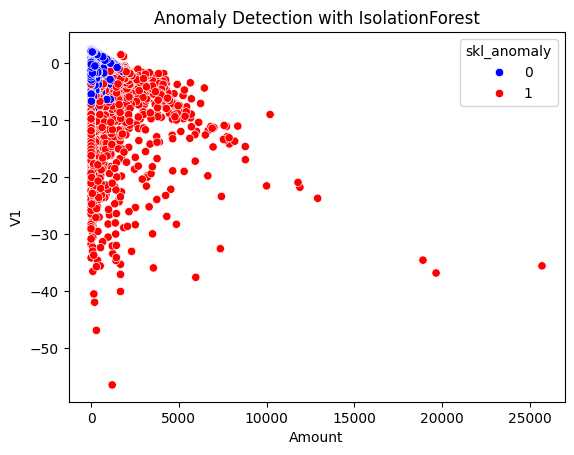

In [14]:
# plotting anomalies over 'Amount' and 'V1'
sns.scatterplot(data=creditcard, x='Amount', y='V1', hue='skl_anomaly', palette={0: "blue", 1: "red"})
plt.title("Anomaly Detection with IsolationForest")
plt.show()

In [15]:
set(creditcard['skl_anomaly'].tolist())

{0, 1}

#### Evaluation

**Evaluating the implemented Isolation Forest:**

In [16]:
#TODO

**Evaluating `sklearn.ensemble.IsolationForest`**


In [17]:
print(classification_report(creditcard['Class'], creditcard['skl_anomaly']))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    284315
           1       0.04      0.82      0.08       492

    accuracy                           0.97    284807
   macro avg       0.52      0.89      0.53    284807
weighted avg       1.00      0.97      0.98    284807

